In [44]:
import pandas as pd
import numpy as np
import data_loader as dl 
import matplotlib
import seaborn

In [2]:
allScanNums = {}

In [3]:
def filter_data(df, cutoff, msfragger=False, prob_column='probability'):
    #drop decoy
    df = df[df["decoy"]==False]
    #sort by qvalue
    df = df.sort_values(prob_column)
    #drop duplicate scans
    df = df.drop_duplicates(subset=["scan"], keep="first") #keep highest coring
    #filter based on qvalue
    if msfragger == False:
        df = df[df[prob_column] <= cutoff]
    else:
        df = df[df[prob_column] >= 1-cutoff]
    return df


In [4]:
#pulling only scan numbers out
def newScanNum(row):
    return(int(row[35:40]))
    


In [5]:
meta = dl.clean_metamorph("2ng")
meta_df = filter_data(meta, .01)
meta_data = meta_df.filter((['scan', 'peptide']))
meta_data

,scan,peptide
0,38422,AEGSDVANAVLDGADCIMLSGETAK
1376,38502,VTIAQGGVLPNIQAVLLPK
1374,21218,KPTDGASSSNCVTDISHLVR
5873,32203,LVSSPCCIVTSTYGWTANMER
5876,15587,NMMAACDPR
...,...,...
17040,24809,SIDFPLTK
14587,40505,DPTAVIFGEDVAFGGVFR
14075,30563,EQQHVMEELFQSSFR
18845,13999,EGGGGKRK


In [6]:
msgf = dl.clean_msgfplus("2ng")
msgfplus_df = filter_data(msgf, .01, )
msgfplus_data = msgfplus_df.filter((['scan', 'peptide']))
msgfplus_data.head()
msgfplus_data

,scan,peptide
0,19653,NMGGPYGGGNYGPGGSGGSGGYGGR
6422,30100,EAAWAISNLTISGR
6423,28960,EEAWVIGSVVAR
6424,24500,DYLLC+57.021DYNR
6425,14802,EGETVEPYK
...,...,...
12126,12477,SETSGPQIK
12130,36687,KQNYMMNFSRQHGLRHFYNRR
28559,25034,FNTPQQPK
12132,13840,FNTPQQPK


In [7]:
msf = dl.clean_msfragger("2ng")
msf['scan'] = msf['scan'].apply(newScanNum) 
msfrag_df = filter_data(msf, .01, msfragger=True)

msfrag_data = msfrag_df.filter((['scan', 'peptide']))
msfrag_data


,scan,peptide
2641,17615,FIMESGAK
13173,40365,VFLENVIR
7305,25429,LVVLATPQVSDSMR
9596,29090,QVEDDIQQLLK
2946,18190,CLTQSGIAGGYK
...,...,...
6754,24567,DIISDTSGDFR
6755,24568,GPVEGYEENEEFLR
6756,24569,LVLLGESAVGK
6750,24561,THSDQFLVAFK


In [8]:
mq = dl.clean_maxquant("2ng")
maxq_df = filter_data(mq, .01)
maxq_data = maxq_df.filter((['scan', 'peptide']))
maxq_data


/Users/daishavanderwatt/Payne_Lab/SingleCellBenchMark/data_loader.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["decoy"] = df.apply(lambda row: make_decoy_col_maxquant(row), axis=1)


,scan,peptide
33067,18289,PGNQNTQVTEAWNK
53134,40678,EILFSVDSSINQSIGGVILFHETLYQK
31499,16565,TNQELQEINR
37796,23490,VDATEESDLAQQYGVR
35548,21018,INEELESQYQQSMDSK
...,...,...
34912,20318,FGISSVPTK
47473,34134,DLEALMFDR
42420,28576,DIFDQLAK
30613,15590,VEEAFNCR


In [9]:
#datalist = dictionary part changing, word = which part getting change, 
#dataSet = which data set is getting added
def add(dataList, word, dataSet):
    temp_list = dataList[word]
    temp_list.append(dataSet)
    dataList[word] = temp_list

def scan_data(dataSet, dataNames, otherDatas):
    for index in dataSet:
        data_Dict = {}
        matches = {'same': [], 'different': [], 'missing':[]}
        scan_num = dataSet.scan[index]
        pep =  dataSet.peptide[index]

        for index in range(3):
            file = otherDatas[index]
            name = dataNames[index]
            temp = file[file.scan == scan_num]

            #check that df isn't empty
            if temp.empty == False: 
                if temp.iloc[0,2] == pep: #check if peps match
                    print("fnd pep: " + temp.iloc[0,2])
                    #print("found scan num: " + str(temp.iloc[0,0]))
                    add(matches, 'same', name)

                else:
                    #print("diff: ")
                    #print("fnd pep: " + temp.iloc[0,1])
                    add(matches, 'different', name)

            #when the scan number is empty
            else:
                add(matches, 'missing', name)
                #print(name + ' was empty')    
        data_Dict[scan_num] = matches
    return data_Dict

Temp_files = [maxq_data, msgfplus_data, msfrag_data]
dataNames = ['MaxQuant', 'MsgfPlus', 'Msfragger']
Meta_dict = scan_data(meta_data, dataNames, Temp_files)
len(Meta_dict)

In [10]:
#Running everything against MM
Meta_dict = {}
Temp_files = [maxq_data, msgfplus_data, msfrag_data]
dataNames = ['MaxQuant', 'MsgfPlus', 'Msfragger']

for index in meta_data.index:
    matches = {'same': [], 'different': [], 'missing':[]}
    scan_num = meta_data.scan[index]
    allScanNums[scan_num] = False
    pep = meta_data.peptide[index]
    #print("Scan Num: " + str(scan_num))
    #print("Peptide: " + str(pep))

    for index in range(3):
        file = Temp_files[index]
        name = dataNames[index]
        temp = file[file.scan == scan_num]
        
        #check that df isn't empty
        if temp.empty == False: 
            if temp.iloc[0,1] == pep: #check if peps match
                #print("fnd pep: " + temp.iloc[0,1])
                #print("found scan num: " + str(temp.iloc[0,0]))
                add(matches, 'same', name)
        
            else:
                #print("diff: ")
                #print("fnd pep: " + temp.iloc[0,1])
                add(matches, 'different', name)
                
        #when the scan number is empty
        else:
            add(matches, 'missing', name)
            #print(name + ' was empty')    
    
    Meta_dict[scan_num] = matches

In [11]:
len(Meta_dict)


13807

In [12]:
#Running everything against Msfragger
Msfrag_dict = {}
Temp_files = [maxq_data, msgfplus_data, meta_data]
dataNames = ['MaxQuant', 'MsgfPlus', 'MetaMorpheus']

for index in msfrag_data.index:
    matches = {'same': [], 'different': [], 'missing':[]}
    scan_num = msfrag_data.scan[index]
    pep = msfrag_data.peptide[index]
    allScanNums[scan_num] = False
    #print("Scan Num: " + str(scan_num))
    #print("Peptide: " + str(pep))
 
    for index in range(3):
        file = Temp_files[index]
        name = dataNames[index]
        temp = file[file.scan == scan_num]
        
        #check that df isn't empty
        if temp.empty == False: 
            if temp.iloc[0,1] == pep: #check if peps match
                #print("fnd pep: " + temp.iloc[0,1])
                #print("found scan num: " + str(temp.iloc[0,0]))
                add(matches, 'same', name)
        
            else:
                #print("diff: ")
                #print("fnd pep: " + temp.iloc[0,1])
                add(matches, 'different', name)
                
        #when the scan number is empty
        else:
            add(matches, 'missing', name)
            #print(name + ' was empty')    
    
    Msfrag_dict[scan_num] = matches

In [13]:
#print(Msfrag_dict)

In [14]:
#Running everything against MsgfPlus
MsgfPlus_dict = {}
Temp_files = [maxq_data,  msfrag_data, meta_data]
dataNames = ['MaxQuant', 'Msfragger', 'MetaMorpheus']


for index in msgfplus_data.index:
    matches = {'same': [], 'different': [], 'missing':[]}
    scan_num = msgfplus_data.scan[index]
    allScanNums[scan_num] = False
    pep = msgfplus_data.peptide[index]
    #print("Scan Num: " + str(scan_num))
    #print("Peptide: " + str(pep))

    for index in range(3):
        file = Temp_files[index]
        name = dataNames[index]
        temp = file[file.scan == scan_num]
        
        #check that df isn't empty
        if temp.empty == False: 
            if temp.iloc[0,1] == pep: #check if peps match
                #print("fnd pep: " + temp.iloc[0,1])
                #print("found scan num: " + str(temp.iloc[0,0]))
                add(matches, 'same', name)
        
            else:
                #print("diff: ")
                #print("fnd pep: " + temp.iloc[0,1])
                add(matches, 'different', name)
                
        #when the scan number is empty
        else:
            add(matches, 'missing', name)
            #print(name + ' was empty')    
    
    MsgfPlus_dict[scan_num] = matches

In [15]:
#print(MsgfPlus_dict)

In [16]:
#Running everything against MaxQuant
MaxQ_dict = {}
Temp_files = [meta_data, msgfplus_data, msfrag_data]
dataNames = ['MetaMorpheus', 'MsgfPlus', 'Msfragger']

for index in maxq_data.index:
    matches = {'same': [], 'different': [], 'missing':[]}
    scan_num = maxq_data.scan[index]
    allScanNums[scan_num] = False
    pep =  maxq_data.peptide[index]
    #print("Scan Num: " + str(scan_num))
    #print("Peptide: " + str(pep))

    for index in range(3):
        file = Temp_files[index]
        name = dataNames[index]
        temp = file[file.scan == scan_num]
        
        #check that df isn't empty
        if temp.empty == False: 
            if temp.iloc[0,1] == pep: #check if peps match
                #print("fnd pep: " + temp.iloc[0,1])
                #print("found scan num: " + str(temp.iloc[0,0]))
                add(matches, 'same', name)
        
            else:
                #print("diff: ")
                #print("fnd pep: " + temp.iloc[0,1])
                add(matches, 'different', name)
                
        #when the scan number is empty
        else:
            add(matches, 'missing', name)
            #print(name + ' was empty')    
    
    MaxQ_dict[scan_num] = matches

In [17]:
#print(MaxQ_dict)

In [18]:
def countUniques(thisDict):
    totalCount = 0
    for scanKey in thisDict:
        scanValue = thisDict[scanKey]
        if len(scanValue['same']) == 0:
            totalCount +=1
    return totalCount
            

In [19]:
#get a list that gives scan numbers for same/different positions of dataSet in relation to another one 
#thisDict = dictionary that we are looking in, dictName = name of data dictionary came from, section = 'same'/'diff'
#dataSet = data we are looking for number of in the dictionary, newList = list to store scan numbers
def getCounts(thisDict, section, dataSet, newList):
    for scanKey in thisDict:
        scanValue = thisDict[scanKey]
        if dataSet in scanValue[section]:
            newList.add(scanKey)
    print('\t' + dataSet + " has " + str(len(newList)) + " scans that are " + section)
    return newList

In [20]:
#printing counts for MM
def printMeta():
    Msfrag_in_Meta = set()
    msfgp_in_Meta = set()
    MaxQ_in_Meta = set()
    print("MetaMorpheus: ")
    MaxQ_in_Meta = getCounts(Meta_dict,'same', 'MaxQuant', MaxQ_in_Meta)
    msfgp_in_Meta = getCounts(Meta_dict,'same', 'MsgfPlus', msfgp_in_Meta)
    Msfrag_in_Meta = getCounts(Meta_dict,'same', 'Msfragger', Msfrag_in_Meta)
    print('\t' + "There are " + str((countUniques(Meta_dict))) + " unique scans where nothing else matches")
    print('\t' + "There are " + str(len(MaxQ_in_Meta.intersection(msfgp_in_Meta, MaxQ_in_Meta))) + " values where all match")

In [21]:
#printing counts for MsFrag
def printMsFrag():
    Meta_in_MsFrag = set()
    msfgp_in_MsFrag = set()
    MaxQ_in_MsFrag = set()
    print("MsFragger: ")
    MaxQ_in_MsFrag = getCounts(Msfrag_dict,'same', 'MaxQuant', MaxQ_in_MsFrag)
    msfgp_in_MsFrag = getCounts(Msfrag_dict,'same', 'MsgfPlus', msfgp_in_MsFrag)
    Meta_in_MsFrag = getCounts(Msfrag_dict,'same', 'MetaMorpheus', Meta_in_MsFrag)
    print('\t' + "There are " + str((countUniques(Msfrag_dict))) + " unique scans where nothing else matches")
    print('\t' + "There are " + str(len(MaxQ_in_MsFrag.intersection(msfgp_in_MsFrag, Meta_in_MsFrag))) + " values where all match")

In [22]:
#printing counts for MsgfPlus
def printMsfgPlus():
    Msfrag_in_MsgfP = set()
    Meta_in_MsgfP = set()
    MaxQ_in_MsgfP = set()
    print("MsgfPlus: ")
    MaxQ_in_MsgfP = getCounts(MsgfPlus_dict,'same', 'MaxQuant', MaxQ_in_MsgfP)
    Meta_in_MsgfP = getCounts(MsgfPlus_dict,'same', 'MetaMorpheus', Meta_in_MsgfP)
    Msfrag_in_MsgfP = getCounts(MsgfPlus_dict,'same', 'Msfragger', Msfrag_in_MsgfP)
    print('\t' + "There are " + str((countUniques(MsgfPlus_dict))) + " unique scans where nothing else matches")
    print('\t' + "There are " + str(len(MaxQ_in_MsgfP.intersection(Meta_in_MsgfP, Msfrag_in_MsgfP))) + " values where all match")


In [23]:
#printing counts for MaxQuant
def printMaxQ():
    Msfrag_in_MaxQ = set()
    msfgp_in_MaxQ = set()
    Meta_in_MaxQ = set()
    print("MaxQuant: ")
    Meta_in_MaxQ = getCounts(MaxQ_dict,'same', 'MetaMorpheus', Meta_in_MaxQ)
    msfgp_in_MaxQ = getCounts(MaxQ_dict,'same', 'MsgfPlus', msfgp_in_MaxQ)
    Msfrag_in_MaxQ = getCounts(MaxQ_dict,'same', 'Msfragger', Msfrag_in_MaxQ)
    print('\t' + "There are " + str((countUniques(MaxQ_dict))) + " unique scans where nothing else matches")
    print('\t' + "There are " + str(len(Meta_in_MaxQ.intersection(msfgp_in_MaxQ, Msfrag_in_MaxQ))) + " values where all match")

In [24]:
#Print everything out
printMeta()
printMsFrag()
printMsfgPlus()
printMaxQ()


MetaMorpheus: 
	MaxQuant has 7861 scans that are same
	MsgfPlus has 8405 scans that are same
	Msfragger has 10072 scans that are same
	There are 2905 unique scans where nothing else matches
	There are 6062 values where all match
MsFragger: 
	MaxQuant has 7991 scans that are same
	MsgfPlus has 8524 scans that are same
	MetaMorpheus has 10072 scans that are same
	There are 764 unique scans where nothing else matches
	There are 5885 values where all match
MsgfPlus: 
	MaxQuant has 6478 scans that are same
	MetaMorpheus has 8405 scans that are same
	Msfragger has 8524 scans that are same
	There are 3013 unique scans where nothing else matches
	There are 5885 values where all match
MaxQuant: 
	MetaMorpheus has 7861 scans that are same
	MsgfPlus has 6478 scans that are same
	Msfragger has 7991 scans that are same
	There are 370 unique scans where nothing else matches
	There are 5885 values where all match


In [25]:
len(allScanNums)

15428

In [26]:
def checkAll(num):
    if num in Meta_dict: 
        if len(Meta_dict[num]['same']) == 3:
            return True
            

In [27]:
#all except for MSGF
def checkMSGF(num):
    if num in Meta_dict:
        if 'Msfragger' in Meta_dict[num]['same'] and 'MaxQuant' in Meta_dict[num]['same'] and 'MsgfPlus' not in Meta_dict[num]['same']:
             return True


In [28]:
def checkMQ(num):
    if num in Meta_dict:
        if 'Msfragger' in Meta_dict[num]['same'] and 'MsgfPlus' in Meta_dict[num]['same'] and 'MaxQuant' not in Meta_dict[num]['same']:
             return True


In [29]:
def checkMSF(num):
    if num in Meta_dict:
        if 'MaxQuant' in Meta_dict[num]['same'] and 'MsgfPlus' in Meta_dict[num]['same'] and 'Msfragger' not in Meta_dict[num]['same']:
             return True


In [30]:
def checkMM(num):
    if num in MsgfPlus_dict:
        if 'MaxQuant' in MsgfPlus_dict[num]['same'] and 'MsgfPlus' in MsgfPlus_dict[num]['same'] and 'MetaMorpheus' not in MsgfPlus_dict[num]['same']:
             return True


In [31]:
 #Meta_dict, Msfrag_dict, MaxQ_dict, MsgfPlus_dict
#dataNames = ['MaxQuant', 'Msfragger', 'MetaMorpheus', 'MsgfPlus', ]

In [32]:
buckets = {'4Same':[], 'LessMsgf':[], 'LessFrag':[], 'LessMeta': [], 'LessMQ':[]}
allSame = []
noMSG = []
noMsF = []
noMM = []
noMQ = []

for num in allScanNums:
    if checkAll(num) == True:
        allSame.append(num)
    elif checkMSGF(num) == True:
        noMSG.append(num)
    elif checkMQ(num) == True:
        noMQ.append(num)
    elif checkMSF(num) == True:
        noMsF.append(num)
        
print('allSame: ' + str(len(allSame)))
print('noMSG: ' + str(len(noMSG)))
print('noMsF: ' + str(len(noMsF)))
print('noMM: ' + str(len(noMM)))
print('noMQ: ' + str(len(noMQ)))        

allSame: 5885
noMSG: 1627
noMsF: 177
noMM: 0
noMQ: 1862


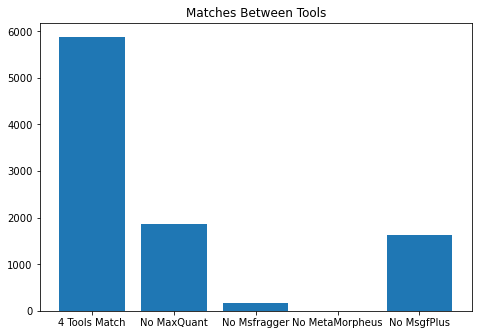

In [33]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
tools = ['4 Tools Match','No MaxQuant', 'No Msfragger', 'No MetaMorpheus', 'No MsgfPlus']
ranges = [len(allSame), len(noMQ), len(noMsF), len(noMM), len(noMSG)]
ax.bar(tools, ranges)
plt.title("Matches Between Tools")
plt.show()


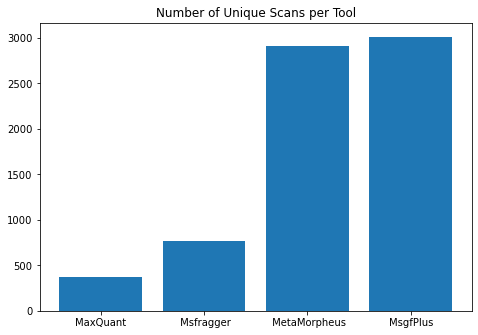

In [34]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
tools = ['MaxQuant', ' Msfragger', ' MetaMorpheus', 'MsgfPlus']
Unique_Scans = [ countUniques(MaxQ_dict), countUniques(Msfrag_dict), countUniques(Meta_dict), countUniques(MsgfPlus_dict)]
ax.bar(tools, Unique_Scans)
plt.title("Number of Unique Scans per Tool")
plt.show()

In [35]:
##For each scan that's missing in only one tool, we need to graph all of the p values

In [36]:
def find_pvals(list_without, dataSet):
    pvals = []
    for num in list_without:
        tempFrame = dataSet[dataSet.scan == num]
        if tempFrame.empty != True:
            pValue = tempFrame.iloc[0,3]
            pvals.append(pValue)
    return pvals

In [37]:
MSG_pvals = find_pvals(noMSG, msgf)
print(len(noMSG))
print(len(MSG_pvals))

1627
1627


In [38]:
MsF_pvals = find_pvals(noMsF, msf)
print(len(noMsF))
print(len(MsF_pvals))

177
134


In [39]:
MQ_pvals = find_pvals(noMQ, mq)
print(len(noMQ))
print(len(MQ_pvals))

1862
1862


In [40]:
##Testing from here down

#another option. Doesn't work with msf
def find_pvals(list_without, dataSet):
    pvals = []
    for num in list_without:
        if num in dataSet['scan']:
            tempFrame = dataSet[dataSet.scan == num]
            pValue = tempFrame.iloc[0,3]
            pvals.append(pValue)
    return pvals

In [41]:
num = 13288
if num in msf.peptide:
    print('yes')
else:
    print('no')
    
print(msf[msf.scan == 13288])

yes
Empty DataFrame
Columns: [decoy, scan, peptide, probability]
Index: []


In [48]:
TestDF = pd.DataFrame([['MSFragger', [1,2]], ['MaxQuant',[2.5,3]], ['MsgfPlus', [1,3]], columns = ['ToolName','P_Value'])

SyntaxError: invalid syntax (<ipython-input-48-58bf4469dc84>, line 1)

ax1 = TestDF.plot.scatter(x = 'ToolName', y = 'P_Value', c = 'black')

x = TestDF['ToolName']
y = TestDF['P_Value']
matplotlib.pyplot.scatter(x,y)

In [ ]:
x = TestDF['ToolName']
y = TestDF['P_Value']
seaborn.stripplot(x, y)